In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cm2inch(*tuple1):
    return tuple(i / 2.54 for i in tuple1)

In [3]:
# %matplotlib notebook
plt.rcParams['font.family'] = 'CMU serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.default'] = 'regular'

In [4]:
center_wavelength = 486.133 # H beta 486.133nm
Tmax = 60
M = 1.008 # atom mass for hydrogen
A = 1.5 # aspect radius 1.5
Rmajor = 200 # major radius 200mm
resolution = 0.0038 # the resolution of the spectrometer, 0.0038nm

In [5]:
# numeric constants
a0 = -2.0e1
a1 = 8.1
a2 = 1.5e-1

# In the following simulation, some functions to be specified...

the emission profile is given by
$$\epsilon_\lambda(r, \lambda) = \frac{\epsilon_0(r)}{\Delta\lambda_{1/2}(r)}\sqrt{\frac{4\ln2}{\pi}}exp[-4\ln2(\frac{\lambda-\lambda_0}{\Delta\lambda_{1/2}(r)})^2]$$


in which $r$ is the radius of the measurement, $\lambda$ is the wavelength; $\Delta\lambda_{1/2}(r)$ is the full width of half maximum, can be described by the following equations:

$$T_i(r)=1.69\times10^8M(\frac{\Delta\lambda_{1/2}(r)}{\lambda_0})^2$$

$$\Delta\lambda_{1/2}(r)=\sqrt{\frac{T_i(r)}{1.69\times10^8M}}\lambda_0$$

Here $M$ is the atom mass, for hydrogen here it is 1.008; $\lambda_0$ is the center wavelength, here it is 486.133 for $H_{\beta}$.




$\epsilon_0(r)$ is the emission rate, and is given here in two types:

$$\epsilon_0(r)=
       \begin{cases}
        -A^2(r/R_{major}-1)^2+1 & peak\\
        \\
        a_0(r/R_{major}-1)^4+a_1(r/R_{major}-1)^2+a_2 & hollow\\
       \end{cases}   $$
       
$T_i(r)$ is the temperature profile, is also given in the following two types:
      
$$T_i(r)=
       \begin{cases}
        T_{max}[-A^2(r/R_{major}-1)^2+1] & peak\\
        \\
        T_{max}[a_0(r/R_{major}-1)^4+a_1(r/R_{major}-1)^2+a_2] & hollow\\
       \end{cases}   $$
       
where $a_0=-20, a_1=8.1, a_2=0.15$ are all numeric constants; $A=1.5$ is the aspect ratio; $R_{major}=200mm$ is the major radius.

## these are the temperature $T_i(r)$ and emission rate $\epsilon_0(r)$
$\epsilon_0(r)$ is the emission rate, and is given here in two types:

$$\epsilon_0(r)=
       \begin{cases}
        -A^2(r/R_{major}-1)^2+1 & peak\\
        \\
        a_0(r/R_{major}-1)^4+a_1(r/R_{major}-1)^2+a_2 & hollow\\
       \end{cases}   $$
       
$T_i(r)$ is the temperature profile, can is given in the following two types
      
$$T_i(r)=
       \begin{cases}
        T_{max}[-A^2(r/R_{major}-1)^2+1] & peak\\
        \\
        T_{max}[a_0(r/R_{major}-1)^4+a_1(r/R_{major}-1)^2+a_2] & hollow\\
       \end{cases}   $$

In [6]:
## piecewise function（分段函数／区分関数）
## this is apparent... that the definition of the emission rate is a piecewise function(分段函数/区分関数)
y_p = lambda r: -A ** 2 * (r/Rmajor - 1) ** 2 + 1 #peak profile
y_h = lambda r: a0 * (r/Rmajor - 1) ** 4 + a1 * (r/Rmajor - 1) ** 2 + a2 #hollow profile

emission_rate_peak = lambda r: np.piecewise(r, [y_p(r)<=0, y_p(r)>0], [0, y_p])
emission_rate_hollow = lambda r: np.piecewise(r, [y_h(r)<=0, y_h(r)>0], [0, y_h])

Ti_peak = lambda r: Tmax * emission_rate_peak(r)
Ti_hollow = lambda r: Tmax * emission_rate_hollow(r)

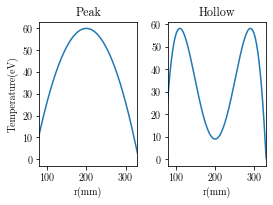

In [7]:
r = np.linspace(0, 400, 400) # one dimensional radius
Tip = Ti_peak(r) 
Tih = Ti_hollow(r)
emission_rate_p = emission_rate_peak(r)
emission_rate_h = emission_rate_hollow(r)


fig, ax = plt.subplots(1, 2, figsize=cm2inch(10, 7.5))
ax[0].plot(r, Tip)
ax[0].set_ylabel('Temperature(eV)')
ax[0].set_xlabel('r(mm)')
ax[0].set_title('Peak')
ax[1].plot(r, Tih)
ax[1].set_xlabel('r(mm)')
ax[1].set_title('Hollow')

fig. tight_layout()
# fig.set_title('Temperature-radius profile')

for i in ax:
    i.margins(x=0)
    i.set_xlim([80, 330])

# Next is the full width of half maximum
that is 
$$\Delta\lambda_{1/2}(r)=\sqrt{\frac{T_i(r)}{1.69\times10^8M}}\lambda_0$$

In [8]:
def FWHM(Ti):
    return np.sqrt(Ti / (1.69e8 * M)) * center_wavelength

# Finally is the emission profile
$$\epsilon_\lambda(r, \lambda) = \frac{\epsilon_0(r)}{\Delta\lambda_{1/2}(r)}\sqrt{\frac{4\ln2}{\pi}}exp[-4\ln2(\frac{\lambda-\lambda_0}{\Delta\lambda_{1/2}(r)})^2]$$

note here that because FWHM can be 0, so special care should be taken in order to avoid the divided by zero error. (those who is divided by 0 should return 0 in this case)

In [9]:
def emission(wavelength, emission_rate, FWHM):
    
    if emission_rate.ndim == 1:
    
        divide_term1 = np.divide((wavelength[:, None]-center_wavelength), FWHM, 
                                out=np.zeros([wavelength.size, FWHM.size]), where=FWHM!=0) #use divide here to avoid 0 problem!!!

        divide_term2 = np.divide(emission_rate, FWHM, out=np.zeros_like(emission_rate), where=FWHM!=0)

        return divide_term2 * np.sqrt(4*np.log(2) / np.pi) * np.exp(-4 * np.log(2) * (divide_term1 ** 2))
    
    elif emission_rate.ndim == 2:
        
        ## use divide here to avoid 0 problem!!!
        divide_term1 = np.divide((wavelength[:, None, None]-center_wavelength), FWHM, 
                                out=np.zeros([wavelength.size, FWHM.shape[0], FWHM.shape[1]]), where=FWHM!=0)
        
        divide_term2 = np.divide(emission_rate, FWHM, out=np.zeros_like(emission_rate), where=FWHM!=0)
        
        return divide_term2 * np.sqrt(4*np.log(2) / np.pi) * np.exp(-4 * np.log(2) * (divide_term1 ** 2))

## Let's check if the profile is correct

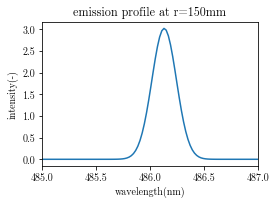

In [10]:
wavelength = np.linspace(485, 487, 100)
emission_profile = emission(wavelength, emission_rate_p, FWHM(Tip))

fig, ax = plt.subplots(figsize=cm2inch(10, 7.5))
ax.plot(wavelength, emission_profile[:, np.abs(r-150).argmin()])
ax.margins(x=0)
ax.set_xlabel('wavelength(nm)')
ax.set_ylabel('intensity(-)')
ax.set_title('emission profile at r=150mm')

fig.tight_layout()

(70.0, 330.0)

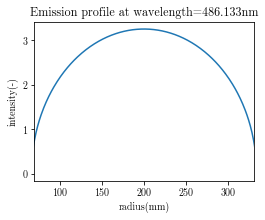

In [11]:
plt.figure(figsize=cm2inch(10, 7.5))
plt.plot(r, emission_profile[np.abs(wavelength-center_wavelength).argmin(), :])
plt.margins(x=0)
plt.xlabel('radius(mm)')
plt.ylabel('intensity(-)')
plt.tight_layout()
plt.title('Emission profile at wavelength=486.133nm')
plt.xlim(70, 330)

## Two dimensional profile
let's check if the two dimensional profile is correct

In [12]:
# two dimensional radiation
x = np.linspace(-320, 320, 200)
y = np.linspace(-320, 320, 200)
X, Y = np.meshgrid(x, y)

R = np.sqrt(X ** 2 + Y ** 2)

emission_rate_p_2d = emission_rate_peak(R)
emission_rate_h_2d = emission_rate_hollow(R)

Ti_p_2d = Ti_peak(R)
Ti_h_2d = Ti_hollow(R)

emission_2d_p = emission(wavelength, emission_rate_p_2d, FWHM(Ti_p_2d))
emission_2d_h = emission(wavelength, emission_rate_h_2d, FWHM(Ti_h_2d))

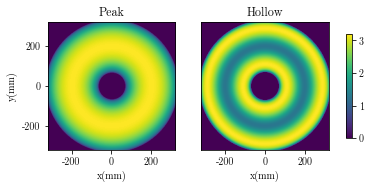

In [13]:
plt.figure(figsize=cm2inch(16, 7.5))
plt.subplot(121)
plt.imshow(emission_2d_p[np.abs(wavelength-center_wavelength).argmin(), :, :], 
           origin='lower', extent=[-320, 320, -320, 320])
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
ax1 = plt.gca()
ax1.set_title('Peak')

plt.subplot(122)
im = plt.imshow(emission_2d_h[np.abs(wavelength-center_wavelength).argmin(), :, :], 
                origin='lower', extent=[-320, 320, -320, 320])
plt.xlabel('x(mm)')
# plt.ylabel('y(mm)')
ax2 = plt.gca()
ax2.set_yticks([])
ax2.set_title('Hollow')

plt.colorbar(im, ax=[ax1, ax2], shrink=0.65)

# fig.tight_layout()

# Now let's do Abel inversion

When the emission coeficient $\epsilon_{\lambda}(r, \lambda)$ is integrated over the line of sight with impact parameter p, the signal $L_\lambda(p, \lambda)$ is given by

$$L_\lambda(p, \lambda)=\int_{-\sqrt{R_{sep}^2-p^2}}^{\sqrt{R_{sep}^2-p^2}}\epsilon_{\lambda}(r, \lambda)dl$$

Via Abel inversion, this integrated signal can be used to obtain original emission coefficient $\epsilon_{\lambda}(r, \lambda)$:

$$\epsilon_{\lambda}(r, \lambda)=-\frac{1}{\pi}\int_r^{R_{sep}}\frac{\partial L_\lambda(p, \lambda)}{\partial p}
    \frac{1}{\sqrt{p^2-r^2}}dp$$

These are to be done in a discrete manner in the computer, given by

$$L_{\lambda}(p_i, \lambda_k)=\sum_{j=0}^N\epsilon_{\lambda}(l_j, p_i, \lambda_k)\Delta l$$
$$\epsilon_{\lambda}(r_n, \lambda_k)=-\frac{1}{\pi}\sum_{m=n+1}^{M}\frac{\Delta L(P_m, \lambda_k)}{\Delta p}\frac{1}{\sqrt{p_m^2-r_n^2}}\Delta y$$

## to begin with, let's generate four types of emission coefficients
in this numerical simulation, there would be a $801\times801$ grid. $-400\leq x,y\leq400mm, \Delta x, \Delta y=1mm$

the place of measurement are $p_i=70, 105, 140, 175, 210, 245, 280(, 315)mm$

In [14]:
dl = 1 ## dl = 1mm
gp = 801 ## grid points = 801*801

x = np.arange(-400, 401, dl) # this way and the way in the next cell are both okay
y = np.arange(-400, 401, dl)

In [15]:
lamda_interval = 0.00400 #deltalambda
lgp = 256 #the total number of wavelength

In [16]:
%%time
# two dimensional radiation
# x = np.linspace(-400, 400, 801)
# y = np.linspace(-400, 400, 801)

X, Y = np.meshgrid(x, y)

# wavelength
wavelength = np.arange(485.6, 485.6+lamda_interval*(lgp-0.5), lamda_interval)

R = np.sqrt(X ** 2 + Y ** 2)

emission_rate_p_2d = emission_rate_peak(R)
emission_rate_h_2d = emission_rate_hollow(R)
Ti_p_2d = Ti_peak(R)
Ti_h_2d = Ti_hollow(R)
## type1, peak emission rate and peak temperature
## note that the [:, None, None] operation here is for broadcast
# emission_2d_t1 = emission(wavelength, emission_rate_p_2d, FWHM(Ti_p_2d))
# # type2, peak emission rate and hollow temperature
# emission_2d_t2 = emission(R, wavelength[:, None, None], emission_rate_p_2d, FWHM(Ti_h_2d)) 
# # type3, hollow emission rate and peak temperture
# emission_2d_t3 = emission(R, wavelength[:, None, None], emission_rate_h_2d, FWHM(Ti_p_2d)) 
# # type4, hollow emission rate and hollow temperature
emission_2d_t1 = emission(wavelength, emission_rate_h_2d, FWHM(Ti_h_2d))


Wall time: 2.36 s


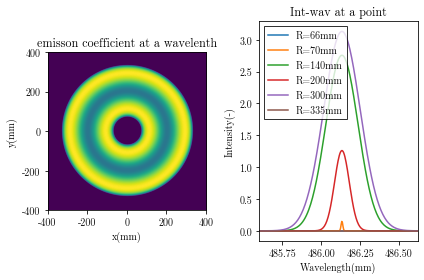

In [17]:
plt.subplot(121)
plt.imshow(emission_2d_t1[np.abs(wavelength-486.133).argmin(), :, :], extent=[-400, 400, -400,400])
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.gca().set_title('emisson coefficient at a wavelenth')
# plt.colorbar()

plt.subplot(122)

m, n = np.unravel_index(np.abs((R-66)).argmin(), R.shape) # this method can be used to find where in the grid the R is some value
plt.plot(wavelength, emission_2d_t1[:, m, n], label='R=66mm')

m, n = np.unravel_index(np.abs((R-70)).argmin(), R.shape) # this method can be used to find where in the grid the R is some value
plt.plot(wavelength, emission_2d_t1[:, m, n], label='R=70mm')

m, n = np.unravel_index(np.abs((R-140)).argmin(), R.shape) # this method can be used to find where in the grid the R is some value
plt.plot(wavelength, emission_2d_t1[:, m, n], label='R=140mm')

m, n = np.unravel_index(np.abs((R-200)).argmin(), R.shape) # this method can be used to find where in the grid the R is some value
plt.plot(wavelength, emission_2d_t1[:, m, n], label='R=200mm')

m, n = np.unravel_index(np.abs((R-300)).argmin(), R.shape) # this method can be used to find where in the grid the R is some value
plt.plot(wavelength, emission_2d_t1[:, m, n], label='R=300mm')

m, n = np.unravel_index(np.abs((R-335)).argmin(), R.shape) # this method can be used to find where in the grid the R is some value
plt.plot(wavelength, emission_2d_t1[:, m, n], label='R=335mm')

plt.legend(loc='upper left', fancybox=False, edgecolor='k')

plt.margins(x=0)
plt.xlabel('Wavelength(mm)')
plt.ylabel('Intensity(-)')
plt.gca().set_title('Int-wav at a point')

plt.tight_layout()

##  Now let's intergrate the emission
implementing the integration as the following equation is as simple as take the sum
$$L_{\lambda}(p_i, \lambda_k)=\sum_{j=0}^N\epsilon_{\lambda}(l_j, p_i, \lambda_k)\Delta l$$

In [18]:
%%time
L_prjected = np.sum(emission_2d_t1, axis=1) * dl ## integrating to get the signal

Wall time: 70 ms


then we extract a few points of interest and spline interpolate

In [19]:
from scipy.interpolate import interp1d
from scipy import interpolate

Text(0.5, 1.0, 'The orginal signal and the interpolated')

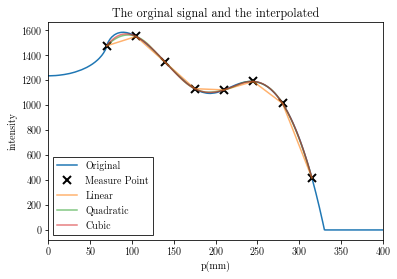

In [20]:
## the real projected data
plt.plot(y, L_prjected[np.abs(wavelength-486.133).argmin(), :], label='Original')
plt.margins(x=0)
plt.xlabel('p(mm)')
plt.ylabel('intensity')
plt.xlim(0, 400) ## since it's sysmetric, we just need one side.

## now find the points we want and add them to the list
p = [70, 105, 140, 175, 210, 245, 280, 315]
L_points = []
for i in p:
    L_points.append(L_prjected[np.abs(wavelength-486.133).argmin(), np.abs(y-i).argmin()])
    
plt.plot(p, L_points, 'kx', ms=8, mew=2, label='Measure Point')

a = 0.6

## first order interpolation
f = interp1d(p, L_points)
p_interp = np.linspace(np.min(p), np.max(p), 1001)
L_interp = f(p_interp)
plt.plot(p_interp, L_interp, label='Linear', alpha=a)

## second order interpolation
f = interp1d(p, L_points, kind='quadratic')
p_interp = np.linspace(np.min(p), np.max(p), 1001)
L_interp = f(p_interp)    
plt.plot(p_interp, L_interp, label='Quadratic', alpha=a)


## third order interpolation
f = interp1d(p, L_points, kind='cubic')
p_interp = np.linspace(np.min(p), np.max(p), 1001)
L_interp = f(p_interp)    
plt.plot(p_interp, L_interp, label='Cubic', alpha=a)

plt.legend(fancybox=False, edgecolor='k')

plt.title('The orginal signal and the interpolated')

## Now to invert the signal
We will take the second order spline fitting.

In [21]:
p_index = [np.abs(y-i).argmin() for i in p]
L_points_all_wavelength = L_prjected[:, p_index]

To interpolate  vectorly, use the axis=1 key word.

In [22]:
p_interp, delta_p = np.linspace(70, 335, 1001, retstep=True)

In [42]:
L_points_all_wavelength.shape

(256, 8)

In [44]:
p

[70, 105, 140, 175, 210, 245, 280, 315]

In [23]:
fc = interpolate.CubicSpline(p, L_points_all_wavelength, axis=1, bc_type='natural')

In [24]:
L_intp_all_wavelength = fc(p_interp)

In [25]:
L_intp_all_wavelength[L_intp_all_wavelength<0] = 0

check if the vectorized calculation is correct...

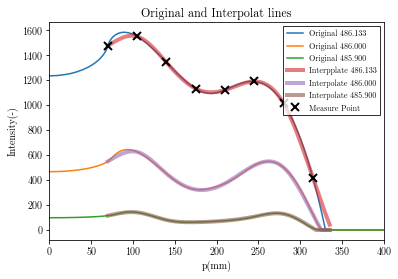

In [26]:
plt.plot(y, L_prjected[np.abs(wavelength-486.133).argmin(), :], label='Original 486.133')
plt.plot(y, L_prjected[np.abs(wavelength-486).argmin(), :], label='Original 486.000')
plt.plot(y, L_prjected[np.abs(wavelength-485.9).argmin(), :], label='Original 485.900')

plt.xlim(0, 400)

plt.plot(p_interp, L_intp_all_wavelength[np.abs(wavelength-486.133).argmin(), :], label='Interpplate 486.133', alpha=0.6, lw=4)
plt.plot(p_interp, L_intp_all_wavelength[np.abs(wavelength-486).argmin(), :], label='Interpolate 486.000', alpha=0.6, lw=4)
plt.plot(p_interp, L_intp_all_wavelength[np.abs(wavelength-485.9).argmin(), :], label='Interpolate 485.900', alpha=0.6, lw=4)

plt.plot(p, L_points, 'kx', ms=8, mew=2, label='Measure Point')

plt.xlabel('p(mm)')
plt.ylabel('Intensity(-)')
plt.title('Original and Interpolat lines')

plt.legend(fancybox=False, edgecolor='k', loc='upper right', fontsize=8)

## Now let's implement the inversion
which is given by the following equation:

$$\epsilon_{\lambda}(r, \lambda)=-\frac{1}{\pi}\int_r^{R_{sep}}\frac{\partial L_\lambda(p, \lambda)}{\partial p}
    \frac{1}{\sqrt{p^2-r^2}}dp           (contiuous)$$

$$\epsilon_{\lambda}(r_n, \lambda_k)=-\frac{1}{\pi}\sum_{m=n+1}^{M}\frac{\Delta L(P_m, \lambda_k)}{\Delta p}\frac{1}{\sqrt{p_m^2-r_n^2}}\Delta y     (discrete)$$

In [27]:
def invert_emission(rn):
    
    I = p_interp>rn
    
    term1 = (np.diff(L_intp_all_wavelength, axis=1)[:, I[1:]] / delta_p)
    
    term2 = 1 / np.sqrt(p_interp[I]**2 - rn**2)
    
    term  = term1 * term2 * delta_p
        
    return np.sum(term, axis=1) / -np.pi

In [28]:
r = np.linspace(70, 335, 250)
Tip = Ti_peak(r)
Tih = Ti_hollow(r)
emission_rate_p = emission_rate_peak(r)
emission_rate_h = emission_rate_hollow(r)

In [29]:
reconstructed_emission = np.zeros([wavelength.size, r.size])

for i, ri in enumerate(r):
    reconstructed_emission[:, i] = invert_emission(r[i])

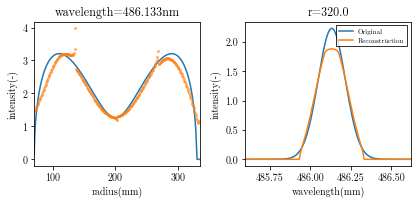

In [30]:
plt.figure(figsize=cm2inch(15, 7.5))
plt.subplot(121)
emission_profile_r = emission(wavelength, emission_rate_h, FWHM(Tih))
plt.plot(r, emission_profile_r[np.abs(wavelength-center_wavelength).argmin(), :])
plt.margins(x=0)
plt.xlabel('radius(mm)')
plt.ylabel('intensity(-)')
plt.tight_layout()
plt.title('wavelength=486.133nm')

plt.plot(r, reconstructed_emission[np.abs(wavelength-center_wavelength).argmin(), :],
         'o', ms=2, alpha=0.5)

plt.subplot(122)

r1=320
emission_profile = emission(wavelength, emission_rate_h, FWHM(Tih))
plt.plot(wavelength, emission_profile[:, np.abs(r-r1).argmin()], label='Original')
plt.title('r=%.1f' %r1)
plt.margins(x=0)
plt.xlabel('wavelength(mm)')
plt.ylabel('intensity(-)')

plt.plot(wavelength, reconstructed_emission[:, np.abs(r-r1).argmin()], label='Reconstruction')

plt.legend(fancybox=False, edgecolor='k', loc='upper right', fontsize=7)

plt.tight_layout()

# plt.savefig('./Draft4 successful case p_4000.jpg', dpi=600)

# Gaussian fitting

For plasma, with a Maxwellian distribution of temperature $T_i$, the obtained spectral line shape is given by:

$$I(\lambda)=\frac{\epsilon_0}{\sigma\sqrt{2\pi}}exp\bigg[-\frac{1}{2}\big(\frac{\lambda-\lambda_0}{\sigma}\big)^2\bigg]$$

the full width half maximum is given by:

$$\Delta\lambda_{\frac{1}{2}}=2\sigma\sqrt{2\ln2}$$

$$\Rightarrow T_i=1.69\times10^8M\bigg(\frac{\Delta\lambda_{\frac{1}{2}}}{\lambda_0}\bigg)^2$$

where $M$ is the atom mass

In [31]:
def line_shape(wavelength, ep, c, s):
    return  ep / s / np.sqrt(2 * np.pi)* np.exp(-0.5 * ((wavelength - c) / s) ** 2) 
   # better to not simplify the fisrt term as a single amplifier, otherwise the sigma might be negative

In [32]:
from scipy.optimize import curve_fit

In [33]:
def Temperature_recover(r):
    Ti_fit = np.zeros_like(r)
    for i, ri in enumerate(r):
        
        line_profile = reconstructed_emission[:, np.abs(r-ri).argmin()]
        
        if np.mean(line_profile == 0):
            Ti_fit[i] = 0
        else:
            
            [emission_rate_opt, center_wavelength_opt, sigma_opt], pcov = curve_fit(line_shape, 
                                                                  wavelength, line_profile, 
                                                                  p0=[1, 486.1, 1])
            FWHM_opt = 2 * sigma_opt * np.sqrt(2 * np.log(2))
            Ti_fit[i] = 1.69e8 * M * (FWHM_opt / center_wavelength_opt) ** 2
    
    return Ti_fit

In [34]:
# %matplotlib notebook

Text(0, 0.5, 'Temperature(eV)')

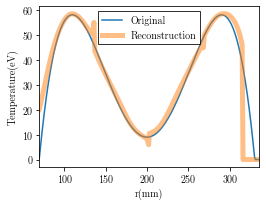

In [35]:
plt.figure(figsize=cm2inch(10, 7.5))

plt.plot(r, Ti_hollow(r), label='Original')

plt.plot(r, Temperature_recover(r), alpha=0.5, lw=5, label='Reconstruction')
plt.margins(x=0)

plt.legend(fancybox=False, edgecolor='k', loc='upper center', fontsize=10)

plt.xlabel('r(mm)')
plt.ylabel('Temperature(eV)')

# Do the Baladin method

In the discrete Abel inversion, as in the equation, the term $\frac{1}{\sqrt{p_m^2-r_n^2}}$ contributes greatly to the numeric error of the reconstruction. 

Baladin recommend using the analytic solution $\int(p^2-r^1)^{-1/2}=\ln(p+\sqrt{p^2-r^2})$. Using this, the discrete reconstruction becomes:
$$\epsilon_\lambda(r_n, \lambda_k)=-\frac{1}{\pi}\sum^M_{m=n}\frac{\Delta L_\lambda(p_m, \lambda_k)}{\Delta P}\int^{r_{i+1}}_{r_i}\frac{1}{\sqrt{p_m^2-r_n^2}dp}$$
$$=-\frac{1}{\pi}\sum^M_{m=n}\frac{\Delta L_\lambda(p_m, \lambda_k)}{\Delta P}\times\ln\bigg[\frac{r_{m+1}(1+\sqrt{1-r_n^2/r_{m+1}^2})}{r_{m}(1+\sqrt{1-r_n^2/r_{m}^2})}\bigg]$$

In [36]:
def invert_emission_baladin(r):
    '''in this method, r and p should have the same dimension.'''
    
    reconstructed_emission_baladin = np.empty([wavelength.size, r.size-1])
    
    for n, rn in enumerate(r[:-1]):
    
        term1 = (np.diff(L_intp_all_wavelength, axis=1)[:, n:] / delta_p)

        term2 = np.log(r[n+1:] * (1 + np.sqrt(1-(rn/r[n+1:]) ** 2))) - np.log(r[n:-1] * (1 + np.sqrt(1-(rn/r[n:-1]) ** 2)))
        
        term  = term1 * term2
        
        reconstructed_emission_baladin[:, n] = term.sum(axis=1) / -np.pi
        
    return reconstructed_emission_baladin

In [37]:
%%time
r_baladin = p_interp.copy()
reconstructed_emission_baladin = invert_emission_baladin(r_baladin)

Wall time: 929 ms


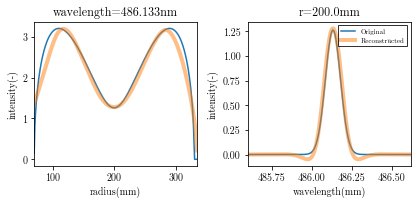

In [38]:
plt.figure(figsize=cm2inch(15, 7.5))
plt.subplot(121)
emission_profile = emission(wavelength, emission_rate_h, FWHM(Tih))
plt.plot(r, emission_profile[np.abs(wavelength-center_wavelength).argmin(), :])
plt.margins(x=0)
plt.xlabel('radius(mm)')
plt.ylabel('intensity(-)')
plt.tight_layout()
plt.title('wavelength=486.133nm')

plt.plot(r_baladin[:-1], reconstructed_emission_baladin[np.abs(wavelength-center_wavelength).argmin(), :],
         lw=4, alpha=0.5)

plt.subplot(122)

r1=200
plt.plot(wavelength, emission_profile[:, np.abs(r-r1).argmin()], label='Original')
plt.title('r=%.1fmm' %r1)
plt.margins(x=0)
plt.xlabel('wavelength(mm)')
plt.ylabel('intensity(-)')

plt.plot(wavelength, reconstructed_emission_baladin[:, np.abs(r_baladin-r1).argmin()], label='Reconstructed',
        lw=4, alpha=0.5)

plt.legend(fancybox=False, edgecolor='k', loc='upper right', fontsize=7)

plt.tight_layout()

# plt.savefig('./Draft4 successful case p_4000.jpg', dpi=600)

# Temperature Reconstruction 

In [39]:
Ti_fit = np.zeros_like(r_baladin)

for i, ri in enumerate(r_baladin[:-1]):

    line_profile = reconstructed_emission_baladin[:, np.abs(r_baladin-ri).argmin()]
    
    if np.mean(line_profile == 0):
        Ti_fit[i] = 0
    else:
        try:
            [emission_rate_opt, center_wavelength_opt, sigma_opt], pcov = curve_fit(line_shape, 
                                                                          wavelength, line_profile, 
                                                                          p0=[1, 486.1, 1])
            FWHM_opt = 2 * sigma_opt * np.sqrt(2 * np.log(2))
            Ti_fit[i] = 1.69e8 * M * (FWHM_opt / center_wavelength_opt) ** 2
                       
        except RuntimeError:
            print(ri)

E:\Programs\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0, 'r(mm)')

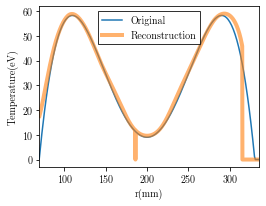

In [40]:
plt.figure(figsize=cm2inch(10, 7.5))
plt.plot(r, Ti_hollow(r), label='Original')
plt.plot(r_baladin[r_baladin>[70]], Ti_fit[r_baladin>[70]], label='Reconstruction', lw=4, alpha=0.6)
plt.margins(x=0)
plt.legend(fancybox=False, edgecolor='k', loc='upper center')

plt.ylabel('Temperature(eV)')
plt.xlabel('r(mm)')

In [41]:
L_intp_all_wavelength.shape

(256, 1001)